# Exploring NC3Rs Experiment Design Assistant File Format from a Template

Here I go through the details off an NC3Rs Experiment Design Assistant `.eda` file. This file is the exported `.eda` file from a template. 

This is their website:  https://eda.nc3rs.org.uk/

In [1]:
import json

f = open('model', 'r')
j = json.load(f)

print("Model JSON Contains primary keys:\n")
for _k in j.keys():
    print(f"  {str(type(j[_k])):15s} {_k} ")

Model JSON Contains primary keys:

  <class 'str'>   resourceId 
  <class 'dict'>  properties 
  <class 'dict'>  propertyTypes 
  <class 'dict'>  stencil 
  <class 'list'>  childShapes 
  <class 'dict'>  bounds 
  <class 'dict'>  stencilset 
  <class 'list'>  ssextensions 


Now, I want to unpack each of these.First, I can see that many of these are dictionaries, but they are actually quite small with the exception of `childShapes`.


| Name | Description | Example |
| --- | --- | --- |
| resourceId | UID | 'oryx-canvas123' |
| properties | Properties | {'title': ""} |
| propertyTypes | Property data types | {'title': 'string'} |
| stencil		| Label | {'id': 'Diagram'} |
| childShapes	| Details of diagram contents | [more below] |
| bounds		| Diagram canvas bounding box | {'lowerRight': {'x': 1589, 'y': 1050 }, 'upperLeft': {'x': 0, 'y': 0 }} |
| stencilset | Link to a JSON file and namespace | {'url': '/eda/assets/eda/eda-750239aadc9892bd73639e9a7c59cffb.json', 'namespace': 'eda#'} |
| ssextensions | Empty list in the template I downloaded | ? |


Now that this level is mostly characterized, I'll dig into `j['childShapes']`. 

This is where  the bulk of EDA node and edge information, including labels, properties, locations, etc, is stored.

In [2]:
dl = []
for _i in j['childShapes']:
    _l = list(_i.keys())
    new = False
    if len(dl) == 0:
        new = True
    else:
        found = False
        for _d in dl:
            if _l == _d:
                found = True
                break
        if not found:
            new = True
    if new:
        dl.append(_l)

count = 1
for _dl in dl:
    print(f"Unique childShape {count}:")
    for _i in _dl:
        print(f" - {_i}")
    count += 1
    print()

Unique childShape 1:
 - resourceId
 - properties
 - propertyTypes
 - stencil
 - childShapes
 - outgoing
 - incoming
 - bounds
 - dockers

Unique childShape 2:
 - resourceId
 - properties
 - propertyTypes
 - stencil
 - childShapes
 - outgoing
 - incoming
 - bounds
 - dockers
 - target



Since there are only two unique childShapes, we can also quickly show the only unique key between the two is `target`, indicating what is likely the `childShape` associated with an edge.

In [3]:
def diff(l1, l2):
    l1_unique = list(set(l1))
    l2_unique = list(set(l2))
    all_unique = list(set(l1+l2))
    list_diff = [i for i in all_unique 
              if i not in l1_unique 
              or i not in l2_unique]
    return list_diff

print("Difference between two childShapes:")
for _d in diff(dl[0],dl[1]):
    print(f"  - {_d}")

Difference between two childShapes:
  - target


I'm guessing these represent nodes and edges as follows:

    Node <class 'dict'> 
         dict_keys([
            'resourceId', 
            'properties', 
            'propertyTypes', 
            'stencil', 
            'childShapes', 
            'outgoing', 
            'incoming', 
            'bounds', 
            'dockers']) 

    Edge <class 'dict'> 
         dict_keys([
            'resourceId', 
            'properties', 
            'propertyTypes', 
            'stencil', 
            'childShapes', 
            'outgoing', 
            'incoming', 
            'bounds', 
            'dockers', 
            'target']) 

This is helpful because now I can see how to parse each of these.

Again, the only difference in keys here is the `target` key. 

I explored this particular experimental diagram in `iPython`, and I found that `target` contains single resourceId value, and that value appears to correspond with the opposite, apparently `Node` entries. 

Here are the resulting notes:

|Name | Description | Example |  
|---|---|---| 
| resourceId  | UID for each node or edge | | 
| properties  | Properties for each node or edge | | 
| propertyTypes   | Key-Value pairs for data type of each property|| 
| stencil   | Label for each node or edge|| 
| childShapes | Recursive, next level down with unique resourceId's, mostly empty, but captures another layer of notes|| 
| outgoing  | List of Key-Value pairs for resourceId's, presumably outgoing edges|| 
| incoming  | List of Key-Value pairs for resourceId's, presumably incoming edges|| 
| bounds    | Dictionary of coordinates for bounding box (?) | {'lowerRight': {'x': 270, 'y': 575}, 'upperLeft': {'x': 150, 'y': 525}} | 
| dockers   | Pairs of geometric coordinate pairs for edge endpoints (?) | [{'x': 73, 'y': 35}, {'x': -0.9, 'y': 8.2}] | 
| target    | Single-entry dictionary of resourceId for an edge| |

Based on this information, we should be able to read the `.eda` file and gather relevant information to a Neo4j schema. In order to do this, we need to know what is required to fully represent this information in Neo4j. 

I am also curious how to translate the coordinates accurately so we might transfer to Arrows.app and then into a Cypher query. For now, Arrows.app is probably the best way to visually verify we're capturing everything correctly. Bloom or Neo4j Browser will be the next step after that. For now, I will focus on the basic graph requirements:

| Neo4j | EDA | EDA `target` | 
|---|---|---|
| UID | resourceId | N/A |
| Node Label | stencil, id | False |
| Node Properties | properties | False |
| Node Properties | propertyTypes | False |
| Relationship Type | stencil, id | True |
| Relationship Properties | properties | True |
| Relationship Properties | propertyTypes | True |


In [4]:
for _opt in ['resourceId','outgoing','incoming']:
    print(f"{_opt}: \n\t{j['childShapes'][1][_opt]}")

resourceId: 
	oryx_7D22B9C7-F193-40BA-B31A-6D9F1A423D93
outgoing: 
	[{'resourceId': 'oryx_6B6458F7-0B89-4EC6-84DC-F398B6DF3716'}]
incoming: 
	[{'resourceId': 'oryx_6894C16E-1267-478F-B621-B6CA322390F9'}]


If I pick the lone `j['childShapes'][1]['outgoing']`, I find that it involves an edge with name `then` as you can see in the next cell...

In [5]:
# ogID = 'oryx_6B6458F7-0B89-4EC6-84DC-F398B6DF3716'
ogID = j['childShapes'][1]['outgoing'][0]['resourceId']
for _j in j['childShapes']:
    if _j['resourceId'] == ogID:
        print(_j['properties'])

{'name': 'then'}


Likewise, if I choose an `j['childShapes'][1]['incoming']`, I find an edge again, suggesting that these are typically nodes.

In [6]:
ogID = j['childShapes'][1]['incoming'][0]['resourceId']
for _j in j['childShapes']:
    if _j['resourceId'] == ogID:
        print(_j['properties'])

{'name': 'subjected to'}


In [7]:
nodes = []
edges = []
for _j in j['childShapes']:
    if 'target' in _j.keys():
        edges.append(_j)
    else:
        nodes.append(_j)

In [8]:
len(nodes)

23

Now that I have all the nodes, I want to check on these seemingly extraneous `childShapes`. They are all named the same thing: `Variable_category`. I wonder what this is and why it is not treated as a normal node, relationship, or property.

In [9]:
for _n in nodes:
    if len(_n['childShapes']) > 0:
        for _i in _n['childShapes']:
            print(_i['stencil'])
        print()

{'id': 'Variable_category'}

{'id': 'Variable_category'}

{'id': 'Variable_category'}



For this template, at least, no edges contain `childShapes` (see cell below). This makes sense generally, so I'm going to assume that this is generally true, but it would be great to confirm!

In [10]:
for _e in edges:
    if len(_e['childShapes']) > 0:
        for _i in _e['childShapes']:
            print(_i['stencil'])
        print()

In [11]:
class Node():
    def __init__(self, node):
        self.uid = node['resourceId']
        self.prop = node['properties']
        self.proptype = node['propertyTypes']
        self.label = node['stencil']['id']
        self.edge_out = node['outgoing']
        self.edge_in = node['incoming']
        self.bbox = node['bounds']
        self.dock = node['dockers']
        
        
class Edge():
    def __init__(self, edge):
        self.uid = edge['resourceId']
        self.prop = edge['properties']
        self.proptype = edge['propertyTypes']
        self.type = edge['stencil']['id']
        self.edge_out = edge['outgoing']
        self.edge_in = edge['incoming']
        self.bbox = edge['bounds']
        self.dock = edge['dockers']
        self.target = edge['target']['resourceId']
        
        
class Graph():
    
    def __init__(self,nodes,edges):
        self.__n = []
        for _n in nodes:
            self.__n.append(Node(_n))
        self.__e = []
        for _e in edges:
            self.__e.append(Edge(_e))

    def node(self,i):
        return self.__n[i]

    def edge(self,i):
        return self.__e[i]

    def nodes(self):
        return self.__n
    
    def edges(self):
        return self.__e

In [12]:
g = Graph(nodes,edges)

n = g.node(1)

n.label

'Pharmacological_intervention'

In [13]:
e = Edge(edges[1])

e.target

'oryx_EC08DE2B-AB9A-4D0D-B9C6-4C1325D08C76'

Now that I have all of these, I should be able to start connecting the dots, so to speak.

In [14]:
_e = g.edge(0)

e_tmp = _e

e_tmp.edge_in

[{'resourceId': 'oryx_7D22B9C7-F193-40BA-B31A-6D9F1A423D93'}]

In [15]:
e_tmp.edge_out

[{'resourceId': 'oryx_EC08DE2B-AB9A-4D0D-B9C6-4C1325D08C76'}]

In [16]:
n_in = e_tmp.edge_in[0]['resourceId']
n_out = e_tmp.edge_out[0]['resourceId']

In [17]:
for _e in g.edges():
    n_ei = len(_e.edge_in)
    n_eo = len(_e.edge_out)
    print(f" In:  {n_ei}")
    print(f"Out:  {n_eo}")

 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1
 In:  1
Out:  1


In [18]:
for _e in g.edges():
    if _e.uid == n_in or _e.uid == n_out:
        print("MATCH")
    else:
        print(_e.uid)

oryx_6B6458F7-0B89-4EC6-84DC-F398B6DF3716
oryx_03CF673F-AD3F-4887-9FFD-28F79BD1A26F
oryx_1EB712B5-45FD-4DD8-9144-DAA850E72B5E
oryx_78203452-E699-4D81-AFFD-79856475A466
oryx_32C97BEC-9870-4C0A-9662-A593062DA774
oryx_43209FCE-CB0A-4FF2-B762-E8DB2AA20CF9
oryx_8482024B-4B0C-4367-A18D-B533098B495D
oryx_D201E784-9443-4A2F-8E2D-84B32EE28A70
oryx_7DCB1D3B-AA45-4462-8853-6C467465616D
oryx_DCB4FE08-DC82-47FD-B882-E03A1534EF9E
oryx_3E06A1E5-A878-441E-9EB2-03E1DDF2BA17
oryx_7FB0194F-A9BE-4C51-94DB-BD87602B7893
oryx_542A2DA0-EA36-40A6-AE9B-94E84F668475
oryx_7E609FBF-9B70-42A1-B1E6-C063B339838C
oryx_6894C16E-1267-478F-B621-B6CA322390F9
oryx_32CEDB01-591C-4ADC-A091-B7910E1003B0
oryx_8FBC9345-AC59-4C41-BF2C-035AB8CEAA0E
oryx_95954A15-61F9-45BD-A087-70237B2E96A5
oryx_33EE9DCA-9CAC-4FD4-ACA0-FCAF446EEE2E
oryx_1E6FE7D7-F32B-4C34-B6C1-028543D77F7F
oryx_EDD58CFF-587B-442A-8BAB-0FE54428B58F
oryx_B36F95A2-2B06-44C1-8039-A560E8674264
oryx_914BEB50-3204-4E53-8CF2-5FD1E8284E8D
oryx_97A6E627-9336-462E-A97A-FFA08

Based on the above test, it appears the incoming and outgoing signify nodes for each edge, as we might expect. One final test for this is to see if target is the same as outgoing or incoming.

In [19]:
verbose = False
for _e in g.edges():
    if _e.edge_out[0]['resourceId'] == _e.target:
        if verbose:
            print("MATCH")
    else:
        print("UNMATCHED")

Alright, now it seems clear that `target` is redundant and seems to generally match with the single outgoing node. This assumption should be part of a unit test. 

Now, I think I can simplify my transformation classes and get them into a NetworkX graph to keep things simple and powerful.

In [20]:
import json


class Node():
    def __init__(self, node):
        self.uid = node['resourceId']
        self.label = node['stencil']['id']
        
        self.property = node['properties']
        self.propertyType = node['propertyTypes']

        self.outgoing = node['outgoing']
        self.incoming = node['incoming']
        
        _bb = node['bounds']
        self.bbox = _bb
        self.pos = ((_bb['lowerRight']['x']+_bb['upperLeft']['x'])/2,
                    (_bb['lowerRight']['y']+_bb['upperLeft']['y'])/2)
        self.dock = node['dockers']
    
    def expand(self, factor):
        self.pos = (factor*self.pos[0], 
                    factor*self.pos[1])
        
class Edge():
    def __init__(self, edge):
        self.uid = edge['resourceId']
        self.type = edge['stencil']['id']
        
        self.property = edge['properties']
        self.propertyType = edge['propertyTypes']
        
        if len(edge['outgoing']) == 1:
            self.outgoing = edge['outgoing'][0]['resourceId']
        else:
            print("ERROR: Incorrect outgoing count on edge.")
            exit(2)
        if len(edge['incoming']) == 1:
            self.incoming = edge['incoming'][0]['resourceId']
        else:
            print("ERROR: Incorrect incoming count on edge.")
            exit(2)
            
        self.target = edge['target']['resourceId']
        
        self.bbox = edge['bounds']
        self.dock = edge['dockers']
        
        
class Graph():
    
    def __init__(self,eda_fname = 'model'):
        self.load_eda(eda_fname = eda_fname)

    def node(self,uid):
        return self.__n[uid]

    def edge(self,uid):
        return self.__e[uid]
    
    def nodes(self):
        return self.__n
    
    def edges(self):
        return self.__e

    def load_lists(self, nodes, edges):
        self.__n = {}
        for _n in nodes:
            _ntmp = Node(_n)
            self.__n[_ntmp.uid] = _ntmp
        self.__e = {}
        for _e in edges:
            _etmp = Edge(_e)
            self.__e[_etmp.uid] = _etmp
            
    def load_eda(self, eda_fname = 'model'):
        with open(eda_fname, 'r') as f:
            j = json.load(f)

        nodes = []
        edges = []
        for _j in j['childShapes']:
            if 'target' in _j.keys():
                edges.append(_j)
            else:
                nodes.append(_j)

        self.load_lists(nodes, edges)
        
    def expand(self, factor):
        for _n in self.__n.values():
            _n.expand(factor)

g = Graph('model')

In [21]:
g.nodes().keys()

dict_keys(['oryx_EC08DE2B-AB9A-4D0D-B9C6-4C1325D08C76', 'oryx_7D22B9C7-F193-40BA-B31A-6D9F1A423D93', 'oryx_60D2D13D-1474-461B-92DD-9507C12A963F', 'oryx_1F9CF2D0-AEB6-4BD2-9433-DBBD33359151', 'oryx_6ADA59C6-4F05-4BC8-B301-36C3979CC1E2', 'oryx_F633FA6C-DEE8-4EA5-BA97-7152FFFDC3D6', 'oryx_9619A14B-F440-4300-B2C3-A025EC483596', 'oryx_574BA78F-DD20-42F2-8366-28E24B49D8B4', 'oryx_72C196D1-9304-4AE1-8135-B7E8E00800C2', 'oryx_4B442D66-9E93-49CD-AC52-D53970B85213', 'oryx_4D30FC52-5049-4559-8D6C-882D94A1AED9', 'oryx_EDFC434D-224D-4307-85BD-7C62C4ED00E8', 'oryx_65659885-3692-43A7-841C-38769DC89397', 'oryx_EAC972AF-784F-4183-A6F6-1B7D0FD111FE', 'oryx_1991F846-7BFD-422A-A43C-0870A7F9CC41', 'oryx_A3E5B0B7-5A56-47C0-9159-5EE8026A7BB9', 'oryx_607A73B2-3FB4-41CD-8003-4B386C502EA1', 'oryx_86BFA1BB-E9D5-438A-A5CF-E2A61B7603EB', 'oryx_9EBFFFDE-03F3-4C2E-953C-082A05273C98', 'oryx_5A200187-C4B8-4090-9AF7-89FD6DD92EDF', 'oryx_5CA98ED5-26AC-44DD-A6A2-6BFC670A9453', 'oryx_8E81820C-3CD0-499F-8306-8450F5FFECBF',

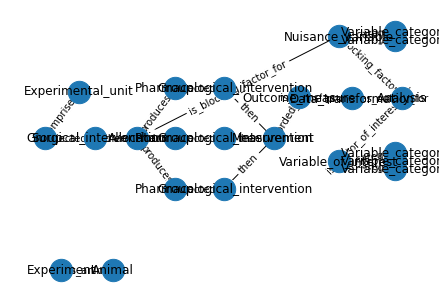

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

g.expand(10)

G = nx.Graph()


label = {'node': {},
         'edge': {}}
position = {}
for _n in g.nodes():
    _uid = g.node(_n).uid    
    G.add_node(_uid)
    label['node'][_uid] = g.node(_n).label
    position[_uid] = g.node(_n).pos
    
for _e in g.edges():
    _in = g.edge(_e).incoming
    _out = g.edge(_e).outgoing
    G.add_edge(_in,_out)
    label['edge'][(_in,_out)] = g.edge(_e).type

plt.figure()
nx.draw(G, pos=position,labels=label['node'],node_size=500)
nx.draw_networkx_edge_labels(G, position, edge_labels=label['edge'])
plt.axis('off')
plt.show()

Alright, this is starting to look good. Here are a couple next steps:

1. Collect childShapes of childShapes... kind of tedious, but whatevs... we need a recursive collection algorithm rather than a list loop. Here, it only misses three seemingly minor nodes, but all the same
2. Next transformation: Arrows.app JSON format is the next target 

Now that it's loading in NetworkX, I'm going to focus on (2). Later, I can add an update for (1).

## Arrows.app JSON

Here is an abbreviated example Arrows.app JSON file:

    {
      "nodes": [
        {
          "id": "n0",
          "position": {
            "x": -143.34846931474965,
            "y": -55.260513818893486
          },
          "caption": "Study",
          "labels": [],
          "properties": {},
          "style": {}
        },
        {
          "id": "n1",
          "position": {
            "x": -194,
            "y": -418.0896465818818
          },
          "caption": "Subject",
          "labels": [],
          "properties": {},
          "style": {}
        },
        {
          "id": "n2",
          "position": {
            "x": 26.690184655924043,
            "y": 224.26880639921308
          },
          "caption": "Investigator",
          "labels": [],
          "properties": {},
          "style": {}
        },
        ...
      ],
      "relationships": [
        {
          "id": "n0",
          "fromId": "n0",
          "toId": "n1",
          "type": "HAS_SUBJECT",
          "properties": {},
          "style": {}
        },
          "id": "n5",
          "fromId": "n0",
          "toId": "n2",
          "type": "DONATED_BY",
          "properties": {},
          "style": {}
        },
        ...
      ],
      "style": {
        "font-family": "sans-serif",
        "background-color": "#ffffff",
        "background-image": "",
        ...
      }
    }

### Arrows.app JSON structure

It's broken into three sections:
1. Nodes
2. Relationships
3. Style

Nodes and Relationships each refer to lists of sets of key-value pairs where each set has the same keys.

Style contains a number of formatting options that aren't super important for now, so that one will mostly be ignored.

#### Nodes

Each node contains the following format:
      
        {
          "id": string,
          "position": {
            "x": float,
            "y": float
          },
          "caption": "",
          "labels": ["<Label1>", "<Label2>", ...],
          "properties": { "propertyName1": valProperty1,
                          "propertyName2": valProperty2,
                          ... },
          "style": {<CustomFormatting/BlankByDefault>}
        }

Here, we want to write
1. UID
2. Position
3. Labels
4. Property Names
5. Property Values
6. Property Types

I'm not sure yet how to explicitly define property types, but Neo4j documents the available types here: https://neo4j.com/docs/cypher-manual/current/syntax/values/

Otherwise, we have everything we need!

#### Relationships

Similarly, relationships cover the same ground, but are even simpler.

        {
          "id": string,
          "fromId": string,
          "toId": string,
          "type": string,
          "properties": { "propertyName1": valProperty1,
                          "propertyName2": valProperty2,
                          ... },
          "style": {<CustomFormatting/BlankByDefault>}
        },

It's worth noting that the relationship "id" scope is limited to the relationships list. This is why there is unique n0 node and a unique n0 edge. It seems like it would be nicer to use an `e` but NBD. I'm going to try replacing these with the EDA-generated UIDs.

Here, we want
1. UID
2. Type
3. fromID ("incoming" node UID)
4. toID ("outgoing" node UID)
5. Property Names
6. Property Values
7. Property Types



In [23]:
def print_arrows_node(xpos,ypos,test,testd):
    print(f"""
    {{
      "id": string,
      "position": {{
        "x": {xpos},
        "y": {ypos}
      }},
      "caption": "",
      "labels": {test},
      "properties": {testd},
      "style": {{}}
    }}
    """)

In [24]:
test = ["here","is","a","test","list"]
testd = {
    "here": "is",
    "a": "dict",
    "list": "to try"
        }
print_arrows_node(123,342,test,testd)


    {
      "id": string,
      "position": {
        "x": 123,
        "y": 342
      },
      "caption": "",
      "labels": ['here', 'is', 'a', 'test', 'list'],
      "properties": {'here': 'is', 'a': 'dict', 'list': 'to try'},
      "style": {}
    }
    


Formatting for the function seems to work just fine. This can be applied to both Nodes and Relationships. I'm going to reintroduce these along with the NetworkX routine into my custom graph classes. Then I will add the ability to return these strings for each node and edge.

In [35]:
import json
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

class Node():
    
    def __init__(self, node, gid):
        self.gid = gid
        self.uid = node['resourceId']
        self.labels = [node['stencil']['id']]
        
        self.property = node['properties']
        self.propertyType = node['propertyTypes']

        self.outgoing = node['outgoing']
        self.incoming = node['incoming']
        
        _bb = node['bounds']
        self.bbox = _bb
        self.pos = ((_bb['lowerRight']['x']+_bb['upperLeft']['x'])/2,
                    (_bb['lowerRight']['y']+_bb['upperLeft']['y'])/2)
        self.dock = node['dockers']
    
    def expand(self, factor):
        self.pos = (factor*self.pos[0], 
                    factor*self.pos[1])
        
    def fstr_arrows(self):
        return {
#             "id": self.gid,
            "id": self.uid,
            "position": {
                "x": self.pos[0],
                "y": self.pos[1]
            },
            "caption": "",
            "labels": self.labels,
            "properties": self.property,
            "style": {}
        }
        
class Edge():
    
    def __init__(self, edge, gid):
        
        self.gid = gid
        self.uid = edge['resourceId']
        self.type = edge['stencil']['id']
        self.name = edge['properties']['name']
        self.property = edge['properties']
        del self.property['name']
        self.propertyType = edge['propertyTypes']
        
        if len(edge['outgoing']) == 1:
            self.outgoing = edge['outgoing'][0]['resourceId']
        else:
            print("ERROR: Incorrect outgoing count on edge.")
            exit(2)
        if len(edge['incoming']) == 1:
            self.incoming = edge['incoming'][0]['resourceId']
        else:
            print("ERROR: Incorrect incoming count on edge.")
            exit(2)
            
        self.target = edge['target']['resourceId']
        
        self.bbox = edge['bounds']
        self.dock = edge['dockers']
        
    def fstr_arrows(self, gid_map):
        return {
            "id": self.gid,
#             "fromId": gid_map[self.incoming],
#             "toId": gid_map[self.outgoing],
            "fromId": self.incoming,
            "toId": self.outgoing,
            "type": self.type,
            "properties": self.property,
            "style": {}
        }

    
class Graph():
    
    def __init__(self,eda_fname = 'model'):
        self.load_eda(eda_fname = eda_fname)
        self.assemble()

    def node(self,uid):
        return self.__n[uid]

    def edge(self,uid):
        return self.__e[uid]
    
    def nodes(self):
        return self.__n
    
    def edges(self):
        return self.__e

    def load_lists(self, nodes, edges):
        self.__n = {}
        i=0
        for _n in nodes:
            _ntmp = Node(_n, f"n{i}")
            self.__n[_ntmp.uid] = _ntmp
            i+=1
        self.__e = {}
        i=0
        for _e in edges:
            _etmp = Edge(_e, f"e{i}")
            self.__e[_etmp.uid] = _etmp
            i+=1
            
    def load_eda(self, eda_fname = 'model'):
        with open(eda_fname, 'r') as f:
            j = json.load(f)

        nodes = []
        edges = []
        for _j in j['childShapes']:
            if 'target' in _j.keys():
                edges.append(_j)
            else:
                nodes.append(_j)

        self.load_lists(nodes, edges)
        
    def expand(self, factor):
        for _n in self.__n.values():
            _n.expand(factor)

    def create_map(self):
        self.__gid = {}
        for _n in self.nodes().values():
            self.__gid[_n.uid] = _n.gid
        for _e in self.edges().values():
            self.__gid[_e.uid] = _e.gid
    
    def create_nx_graph(self):
        self.__G = nx.Graph()
        self.__label = {
            'node': {},
            'edge': {}}
        self.__position = {}
        for _n in self.nodes().values():
            _uid = _n.uid    
            self.__G.add_node(_uid)
            self.__label['node'][_uid] = _n.labels
            self.__position[_uid] = _n.pos
        for _e in self.edges().values():
            _in = _e.incoming
            _out = _e.outgoing
            self.__G.add_edge(_in,_out)
            self.__label['edge'][(_in,_out)] = _e.type

    def assemble(self):
        self.create_map()
        self.create_nx_graph()
    
    def visualize(self):
        plt.figure()
        nx.draw(
            self.__G, 
            pos = self.__position,
            labels = self.__label['node'],
            node_size = 500
               )
        nx.draw_networkx_edge_labels(
            self.__G, 
            self.__position, 
            edge_labels=label['edge'])
        plt.axis('off')
        plt.show()
        
    def export_arrows(self, fpath=None):
        _dtmp = {
            "nodes": [],
            "relationships": [],
            "style": {}
                }
        for _n in self.nodes().values():
            _dtmp['nodes'].append(_n.fstr_arrows())
        for _e in self.edges().values():
            _dtmp['relationships'].append(_e.fstr_arrows(self.__gid))
            
        _dtmp['style'] = {
                "font-family": "sans-serif",
                "background-color": "#ffffff",
                "background-image": "",
                "background-size": "100%",
                "node-color": "#ffffff",
                "border-width": 4,
                "border-color": "#000000",
                "radius": 50,
                "node-padding": 5,
                "node-margin": 2,
                "outside-position": "auto",
                "node-icon-image": "",
                "node-background-image": "",
                "icon-position": "inside",
                "icon-size": 64,
                "caption-position": "inside",
                "caption-max-width": 200,
                "caption-color": "#000000",
                "caption-font-size": 50,
                "caption-font-weight": "normal",
                "label-position": "inside",
                "label-display": "pill",
                "label-color": "#000000",
                "label-background-color": "#ffffff",
                "label-border-color": "#000000",
                "label-border-width": 4,
                "label-font-size": 40,
                "label-padding": 5,
                "label-margin": 4,
                "directionality": "directed",
                "detail-position": "inline",
                "detail-orientation": "parallel",
                "arrow-width": 5,
                "arrow-color": "#000000",
                "margin-start": 5,
                "margin-end": 5,
                "margin-peer": 20,
                "attachment-start": "normal",
                "attachment-end": "normal",
                "relationship-icon-image": "",
                "type-color": "#000000",
                "type-background-color": "#ffffff",
                "type-border-color": "#000000",
                "type-border-width": 0,
                "type-font-size": 16,
                "type-padding": 5,
                "property-position": "outside",
                "property-alignment": "colon",
                "property-color": "#000000",
                "property-font-size": 16,
                "property-font-weight": "normal"
        }
        _darrows = {"graph": _dtmp}
        
        if fpath is None:
            return _darrows
        else:
            with open(fpath, 'w') as _of:
                json.dump(_darrows, _of)

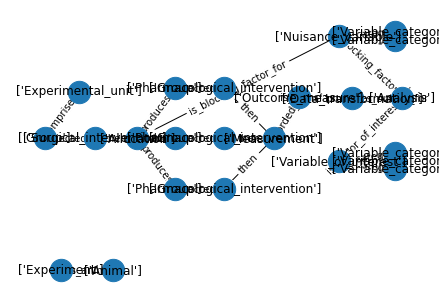

In [36]:
g = Graph('model')
g.visualize()

In [37]:
g.node(list(g.nodes().keys())[0]).fstr_arrows()

{'id': 'oryx_EC08DE2B-AB9A-4D0D-B9C6-4C1325D08C76',
 'position': {'x': 952.5, 'y': 439.001526},
 'caption': '',
 'labels': ['Measurement'],
 'properties': {'description': '',
  'timing': '1h after THC/veh injection',
  'blind_measurement': 'animals individually coded',
  'reason_for_not_blinding': '',
  'additional_information': 'average temperature over 5 min',
  'text': 'Measurement : body temperature'},
 'style': {}}

In [38]:
from pathlib import Path

mountpoint = Path("/mnt/data/cloud/GoogleDrive")
fpath = Path("Data_Infrastructure/Knowledge_Graph/Development/Architecture/NC3Rs-EDA/")
fname = Path("template-schema")
fp = mountpoint.joinpath(fpath,fname)

g.export_arrows(fpath=fp)

Alright! Now that's basically working... Arrows.app doesn't recognize the files on GoogleDrive when I write them from here, but I can manually import the file, and then Arrows.app sees it. 

Here's a manual import of "template-schema"...

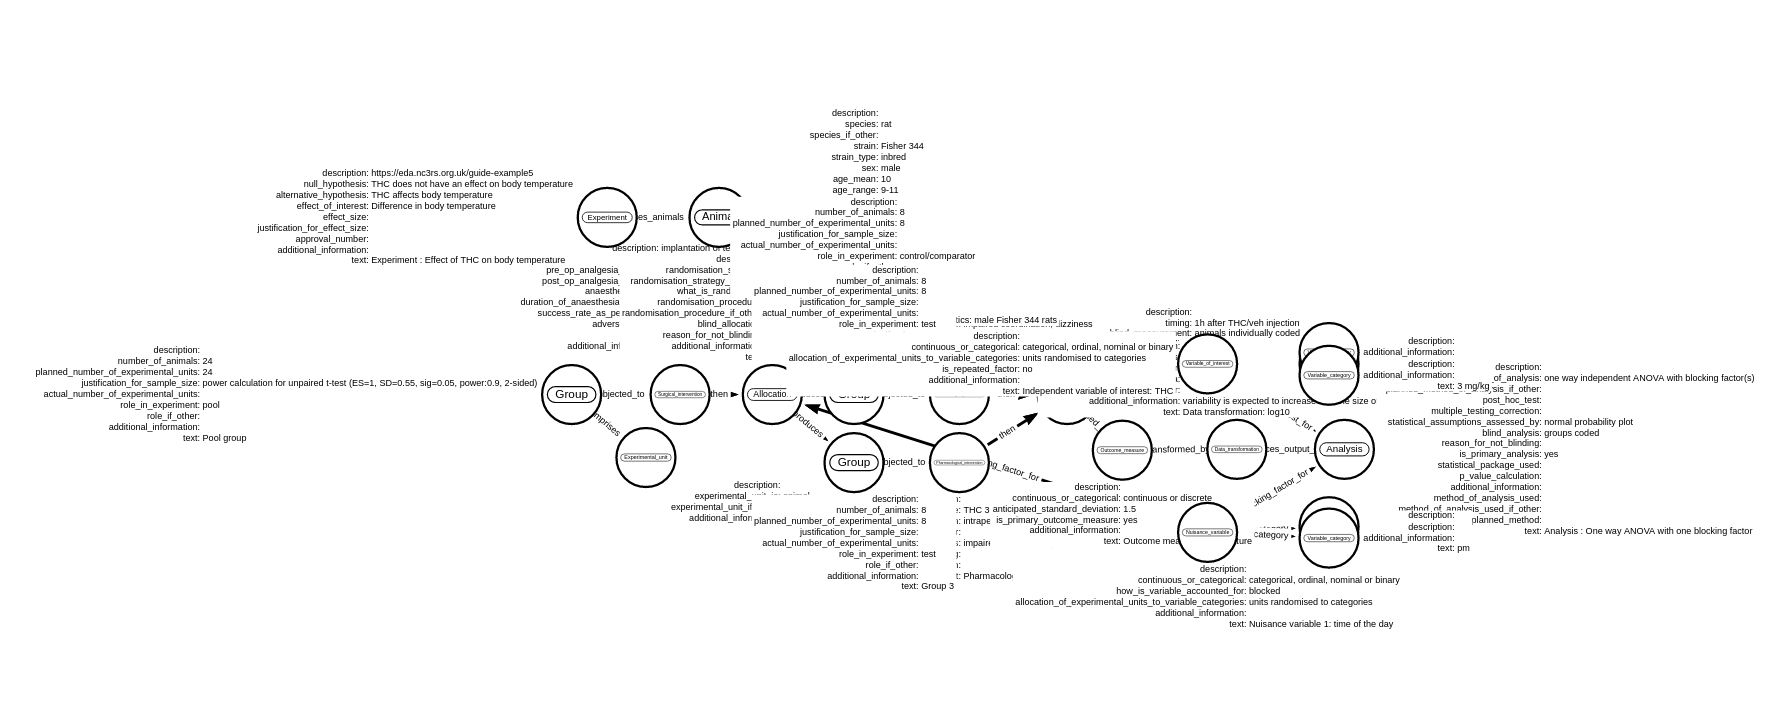

It's pretty messy looking, but I can at least confirm the correct number of nodes and relationships:

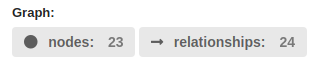

In [39]:
print(f"nodes: {len(g.nodes())}")
print(f"edges: {len(g.edges())}")

nodes: 23
edges: 24


And it checks out! Just to carry all the way through, I loaded it into Neo4j. I did this by manually copying the cypher export from Arrows.app. It seems to have worked as well! Good news.

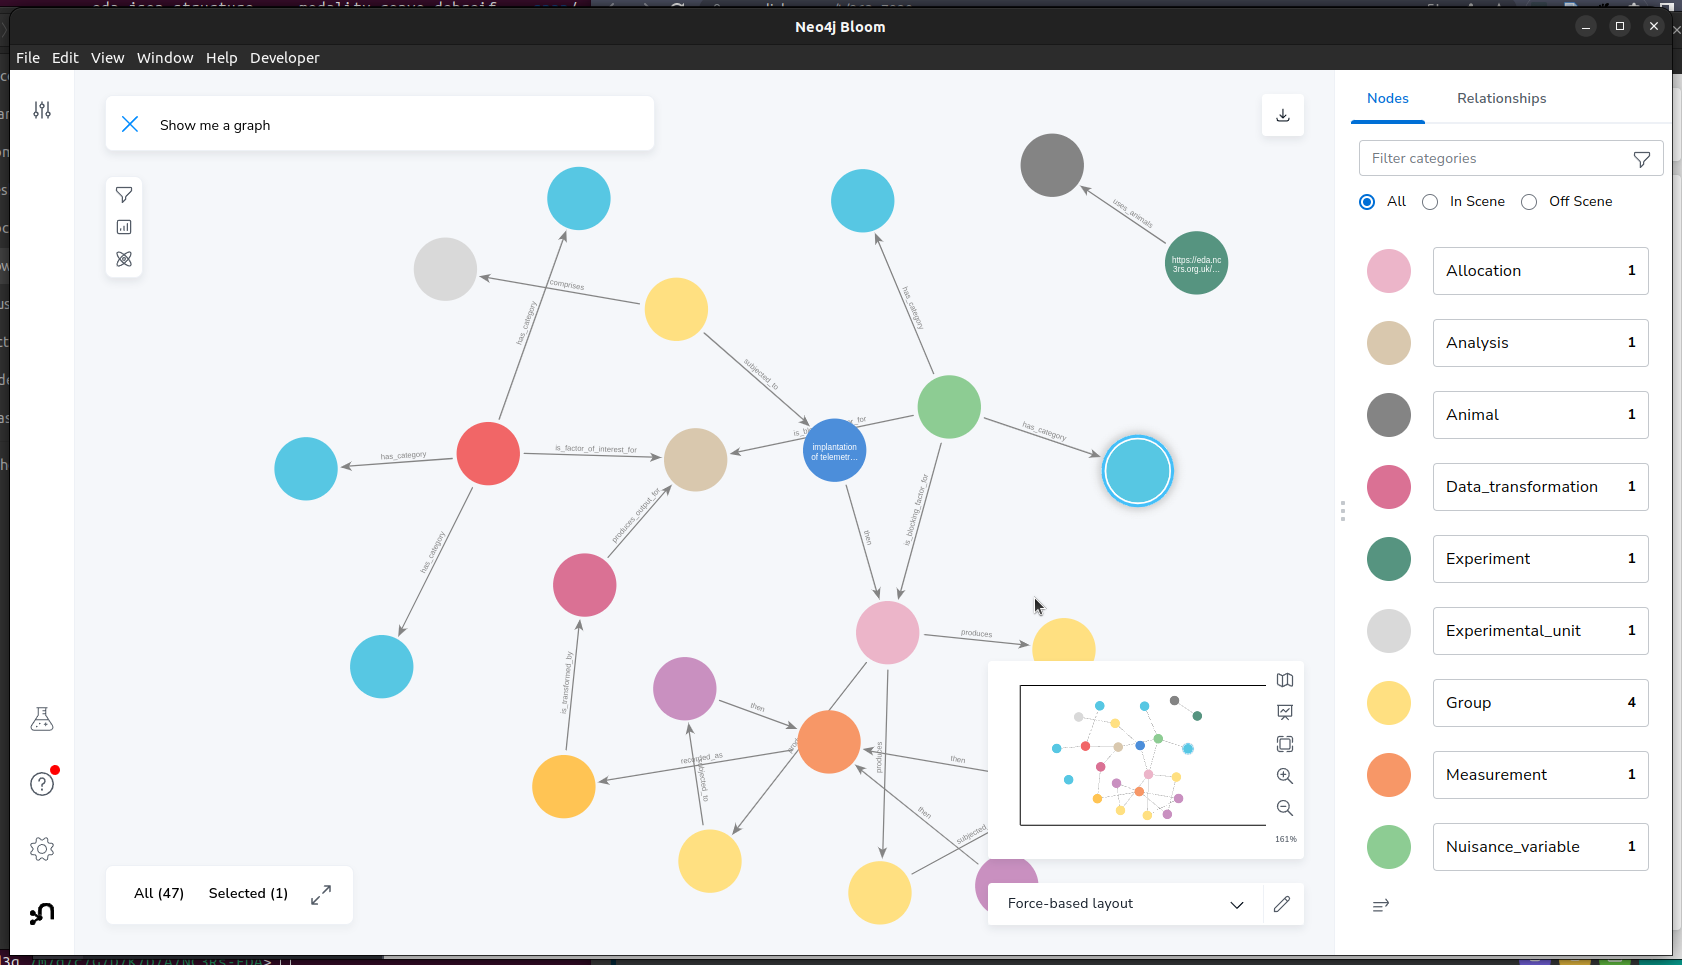

## Neo4j Python API

Now, it's time to try using the Neo4j Python API. 

This should be easier to work with than Arrows.app, and it might also replace some of what I'm doing with NetworkX. Let's see. I'm totally new to the Neo4j API - my initial take is that it's meant more as a driver/wrapper for connecting to and querying a database, rather than handling graphs.

However, their docs indicate relevant graph data types:
https://neo4j.com/docs/api/python-driver/current/api.html#graph-data-types

My interest is piqued... let's give it a try.

In [57]:
from neo4j import graph as neog

In [58]:
ng = neog.Graph()

In [59]:
n_tmp = neog.Node(ng,
                  element_id="testing123",
                  id_=None,
                  n_labels=['Node','Test'],
                  properties={'prop1': 1, 'prop2': 2})

In [60]:
r_tmp = neog.Relationship(ng,
                          element_id="testing123",
                          id_=None,
                          properties={'prop1': 1, 'prop2': 2})

In [61]:
r_tmp

<Relationship element_id='testing123' nodes=(None, None) type='Relationship' properties={'prop1': 1, 'prop2': 2}>

In [62]:
r_tmp.type = "TEST"

AttributeError: can't set attribute

Alright, that was a quick blocker, and it's a bit strange... A relationship has a "type" but it can't be set in the API? Also, it seems like an odd dependency to still REQUIRE the `id_` variable when it's clearly deprecated. Anyway, TBD.

Stopping for now to commit/push and then round up plans for next steps.